In [4]:
import xarray as xr
import rioxarray as rxr
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from module_CBM import *# extract_gaugeRect,aveReflectance,extract_RiverReflectance

In [38]:
path_to_image = "../GEE/WaterExtractedMap_Mississippi10 (1).tif"

In [39]:
bands2d = rxr.open_rasterio(path_to_image)
bands2dWater =bands2d.where(bands2d!=0) #Extracted only water


In [40]:
def calcDist_latlon(x1,y1,x2,y2,r = 6378.137):
    x1 = np.radians(x1)
    y1 = np.radians(y1)
    x2 = np.radians(x2)
    y2 = np.radians(y2)
        
    d = r * np.arccos(np.sin(y1)*np.sin(y2)+np.cos(y1)*np.cos(y2)*np.cos(x2-x1))
    return d
print(calcDist_latlon(-90.15,38.8,-90.25,38.6))

def makeLineFunc(x,p1,p2):
    """
    x:point
    p1:start coordinate
    p2:end coordinate
    """
    slope = (p2[1] - p1[1])/(p2[0]-p1[0]) #y2-y1/x2-x1

    y_value = slope * (x - p1[0]) + p1[1]
    return y_value    

23.898896660198243


## matplotlibによる描画

In [41]:
#各地点の座標
confluence =  [-90.11845811930084,38.810546798605905] #from google map
MS_lower = 	[-90.18, 38.63]# 07010000
MS_upper =  [-90-(22/60)-(16/3600), 38+(57/60)+(4/3600)]  #05587455
MO = [-90-(28/60)-(18.5/3600)-0.002, 38+(47/60)+(13.9/3600)]   #06935965
wavelength = [485,565,660,830]

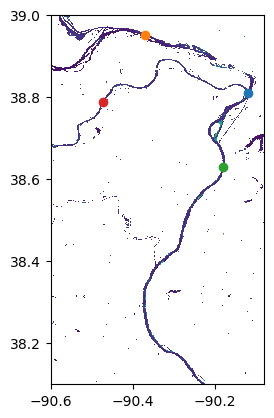

In [42]:
#tiffの描画
fig,ax = plt.subplots()
x = bands2dWater.coords['x'].values
y = bands2dWater.coords['y'].values
X,Y = np.meshgrid(x,y)

ax.pcolormesh(X,Y,bands2dWater.isel(band=0)) #data.sel(band=1)
#ax.set_xlim(-91,-90.0)
#ax.set_ylim(38.3,39.3)
ax.plot(confluence[0],confluence[1],marker="o",label="confluence")
ax.plot(MS_upper[0],MS_upper[1],marker="o",label="MS_upper")
ax.plot(MS_lower[0],MS_lower[1],marker="o",label="MS_lower")
ax.plot(MO[0],MO[1],marker="o",label="MO")
ax.set_aspect("equal")
#fig.savefig("./output/png/MS_obspoint.png",dpi=300,bbox_inches="tight")
plt.show()

In [43]:
#合流部からの直線距離の計算
dist_confToMSL = calcDist_latlon(confluence[0],confluence[1],MS_lower[0],MS_lower[1])
dist_confToMSU = calcDist_latlon(confluence[0],confluence[1],MS_upper[0],MS_upper[1])
dist_confToMO  = calcDist_latlon(confluence[0],confluence[1],MO[0],MO[1])
print(f"Distances are following(km):  \
    \n confluence~MS_lower = {dist_confToMSL}, \n confluence~MS_upper = {dist_confToMSU}, \n confluence~MO = {dist_confToMO}")

Distances are following(km):      
 confluence~MS_lower = 20.796981423220153, 
 confluence~MS_upper = 26.910940691245006, 
 confluence~MO = 30.938222448927977


## 平均反射スペクトルの抽出の実行

In [50]:
def extract_gaugeRect(coordinate,bands2d,xRange=0.001,yRange=0.001):
    bboxXMin,bboxXMax = coordinate[0]-xRange,coordinate[0]+xRange
    bboxYMin,bboxYMax = coordinate[1]-yRange,coordinate[1]+yRange
    print(f"xrange={bboxXMin,bboxXMax},yrange={bboxYMin,bboxYMax}")
    rect = bands2d.sel(x=slice(bboxXMin,bboxXMax),y=slice(bboxYMax,bboxYMin))
    rect.isel(band=0).plot()
    return rect

xrange=(-90.24000000000001, -90.12),yrange=(38.53, 38.730000000000004)


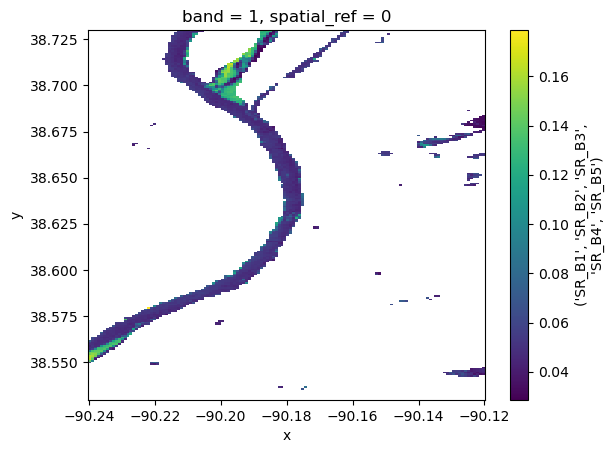

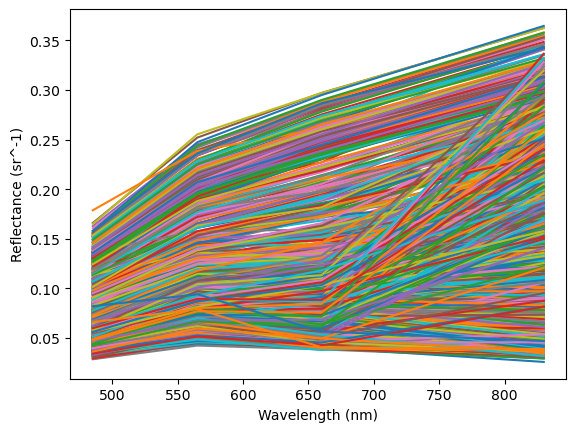

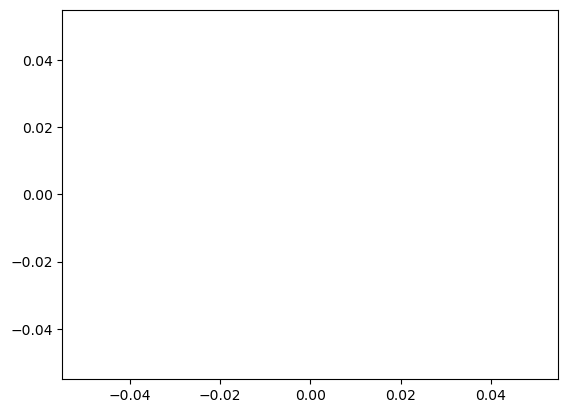

In [51]:
# MS_lower
rect = extract_gaugeRect(MS_lower,bands2d,xRange=0.06,yRange=0.1)
#------when manually modification is needed, uncomment here!------
#region = bands2d.sel(x=slice(-90.18,-90.17),y=slice(38.626,38.634))
#region.isel(band=0).plot()
#-----------------------------------------------------------------
spectrumList = extract_RiverReflectance(rect,title="MSLower Reflectance",figname="reflectance_MSlower.png")
aveSpectrum_MS_lower = aveReflectance(spectrumList)

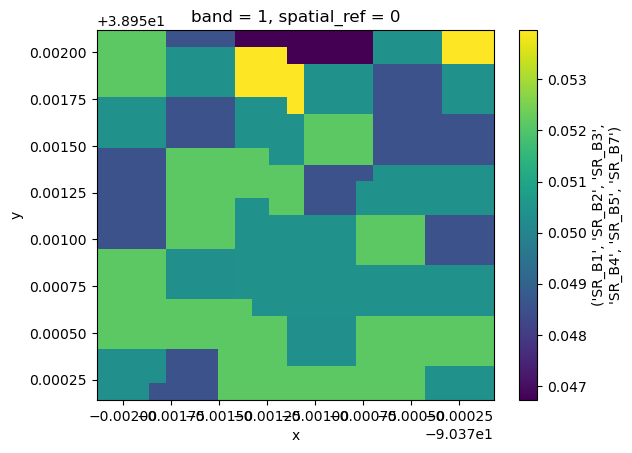

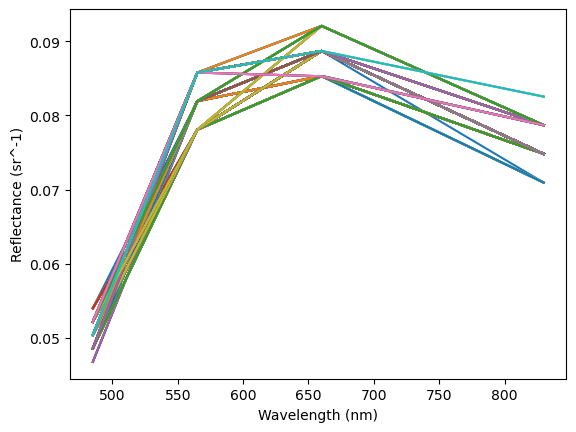

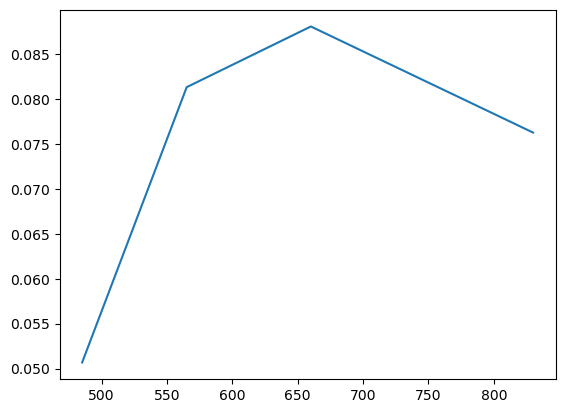

In [10]:
# MS_upper
rect = extract_gaugeRect(MS_upper,bands2d,boxRange=0.001)
#------when manually modification is needed, uncomment here!------
#region = bands2d.sel(x=slice(-90.18,-90.17),y=slice(38.626,38.634))
#region.isel(band=0).plot()
#-----------------------------------------------------------------
spectrumList = extract_RiverReflectance(rect,title="MSUpper Reflectance",figname="reflectance_MSupper.png")
aveSpectrum_MS_upper = aveReflectance(spectrumList)

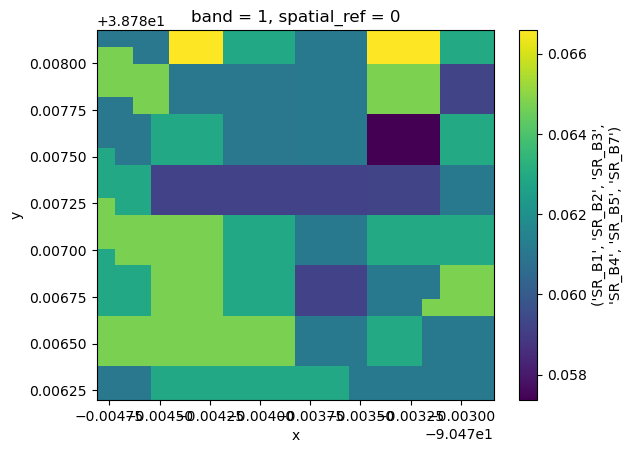

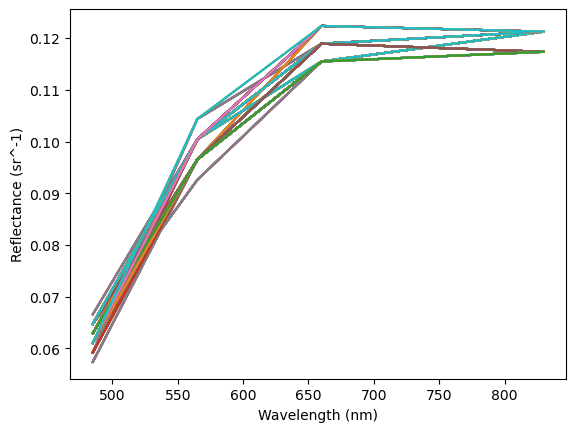

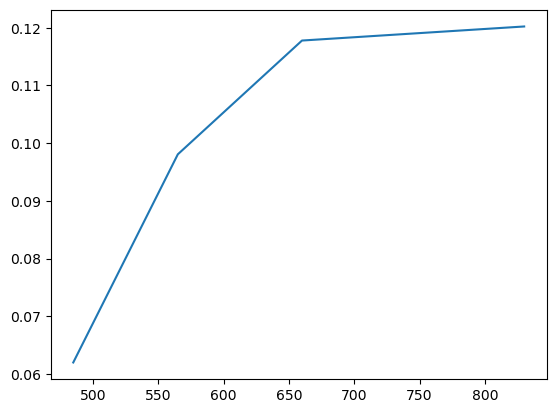

In [12]:
# MO
rect = extract_gaugeRect(MO,bands2d,boxRange=0.001)
#------when manually modification is needed, uncomment here!------
#region = bands2d.sel(x=slice(-90.18,-90.17),y=slice(38.626,38.634))
#region.isel(band=0).plot()
#-----------------------------------------------------------------
spectrumList = extract_RiverReflectance(rect,title="MO Reflectance",figname="reflectance_MO.png")
aveSpectrum_MO = aveReflectance(spectrumList)

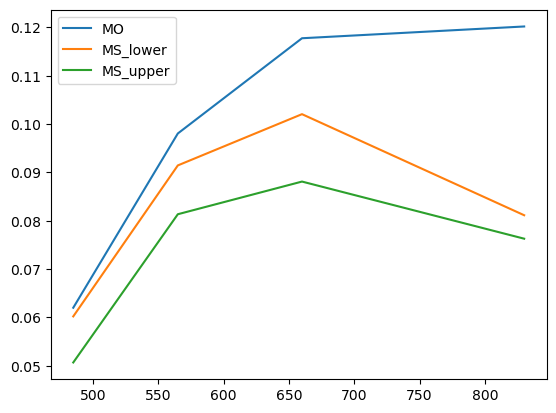

In [13]:
fig,ax = plt.subplots()
ax.plot(wavelength,aveSpectrum_MO,label="MO")
ax.plot(wavelength,aveSpectrum_MS_lower,label="MS_lower")
ax.plot(wavelength,aveSpectrum_MS_upper,label="MS_upper")
ax.legend()
fig.savefig("./output/png/aveSpectrum_all.png",dpi=300,bbox_inches="tight")

In [14]:
#ミズーリ川4106m3/s、ミシシッピ川3540m3/s(合流前)
Q_MS_upper = 3540
Q_MO = 4106
Q_MS_lower = 7646 #Q_MS_upper+Q_MO
Q = [Q_MS_upper,Q_MO,Q_MS_lower]
reflectance = [aveSpectrum_MS_upper,aveSpectrum_MO,aveSpectrum_MS_lower]

In [17]:
def bandRatioFunc(Q,reflectance):
    #既往文献によるとTSSはRedとGreenの組み合わせが良いらしい
    #0:Blue 1:Green 2:Red 3:NIR
    R_by_G = np.zeros(len(reflectance)) #Red/Green 58.26382
    NIR = np.zeros(len(reflectance)) #NIR 40.82293
    R_by_G_plus_NIR = np.zeros(len(reflectance)) #Red/Green + NIR 39.9513
    R = np.zeros(len(reflectance)) #Red 32.27685
    R_by_B = np.zeros(len(reflectance))#Red/Blue 29.71599
    NIR_by_G = np.zeros(len(reflectance))#NIR/Green 23.78704
    R_plus_G_by_2 = np.zeros(len(reflectance))#(Red + Green)/2 20.93913
    NDVI = np.zeros(len(reflectance))#NDVI 18.25673
    B = np.zeros(len(reflectance))    #Blue 13.7215
    SWIR_minus_1 = np.zeros(len(reflectance))    #SWIR-1 13.62441
    R_by_B_plus_B = np.zeros(len(reflectance))   #Red/Blue + Blue 13.09081
    SWIR_minus_1_by_G = np.zeros(len(reflectance))    #SWIR-1/Green 12.74095
    R_by_G_plus_G = np.zeros(len(reflectance))    #Red/Green + Green 11.30311
    SWIR_minus_2 = np.zeros(len(reflectance))    #SWIR-2 10.637
    G = np.zeros(len(reflectance))    #Green 10.05089
    NDSSI = np.zeros(len(reflectance)) #Ax^-bの場合 #https://www.researchgate.net/profile/Akm-Hossain-9/publication/251236287_Development_of_Remote_Sensing_Based_Index_for_EstimatingMapping_Suspended_Sediment_Concentration_in_River_and_Lake_Environments/links/53f34e720cf256ab87b089fe/Development-of-Remote-Sensing-Based-Index-for-Estimating-Mapping-Suspended-Sediment-Concentration-in-River-and-Lake-Environments.pdf
    for i,spectrum in enumerate(reflectance):
        #0:Blue 1:Green 2:Red 3:NIR
        R_by_G[i] = spectrum[2]/spectrum[1]
        NIR[i] = spectrum[3]
        R_by_G_plus_NIR[i] = spectrum[2]/spectrum[1] + spectrum[3]
        R[i] = spectrum[2]
        R_by_B[i] = spectrum[2]/spectrum[0]
        NIR_by_G[i] = spectrum[3]/spectrum[1]
        R_plus_G_by_2[i] = (spectrum[2]+spectrum[1])/2
        NDVI[i] = (spectrum[3]-spectrum[2])/(spectrum[3]+spectrum[2])
        B[i] = spectrum[0]
        R_by_B_plus_B[i] = spectrum[2]/spectrum[0] + spectrum[0]
        R_by_G_plus_G[i] = spectrum[2]/spectrum[1] + spectrum[1]
        G[i] = spectrum[1]
        NDSSI[i] = (spectrum[0] - spectrum[3])/(spectrum[0]+spectrum[3])
    return R_by_G,NIR,R_by_G_plus_NIR,R,R_by_B,NIR_by_G,R_plus_G_by_2,NDVI,B,R_by_B_plus_B,R_by_G_plus_G,G,NDSSI

R_by_G,NIR,R_by_G_plus_NIR,R,R_by_B,NIR_by_G,R_plus_G_by_2,NDVI,B,R_by_B_plus_B,R_by_G_plus_G,G,NDSSI = bandRatioFunc(Q,reflectance)
print(R_by_G,NIR,R_by_G_plus_NIR,R,R_by_B,NIR_by_G,R_plus_G_by_2,NDVI,B,R_by_B_plus_B,G,R_by_G_plus_G,G,NDSSI)
        
    
    
    

[1.08309829 1.20096492 1.11598237] [0.07629368 0.12021041 0.08114681] [1.15939197 1.32117533 1.19712918] [0.08811488 0.11777453 0.10206463] [1.73878286 1.89934299 1.69507558] [0.93779339 1.22580397 0.88726536] [0.08473467 0.10792056 0.09676092] [-0.07190138  0.01023544 -0.1141731 ] [0.05067618 0.06200804 0.06021244] [1.78945904 1.96135103 1.75528801] [0.08135446 0.09806659 0.09145721] [1.16445275 1.29903151 1.20743958] [0.08135446 0.09806659 0.09145721] [-0.20176043 -0.31940989 -0.14809342]


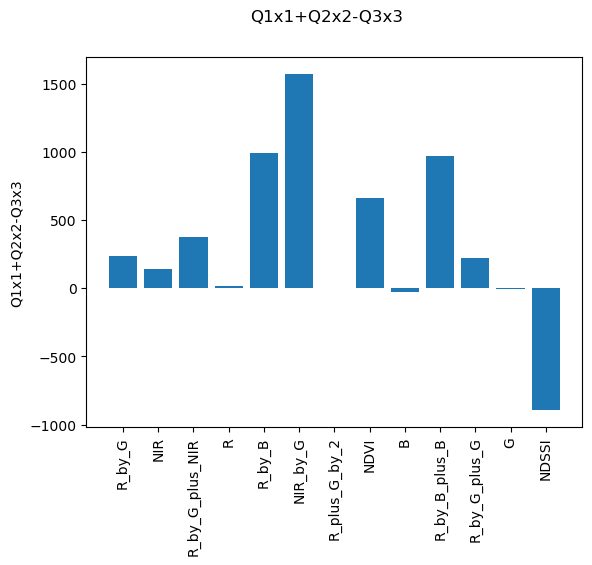

In [18]:
def checkContinuity(Q,x):
    return Q[0]*x[0] + Q[1]*x[1] -Q[2]*x[2]
continuityResult = []
bandRatioList = [R_by_G,NIR,R_by_G_plus_NIR,R,R_by_B,NIR_by_G,R_plus_G_by_2,NDVI,B,R_by_B_plus_B,R_by_G_plus_G,G,NDSSI]
strings = ["R_by_G","NIR","R_by_G_plus_NIR","R","R_by_B","NIR_by_G","R_plus_G_by_2","NDVI","B","R_by_B_plus_B","R_by_G_plus_G","G","NDSSI"]
for x in bandRatioList:
    continuity = checkContinuity(Q,x)
    continuityResult.append(continuity)
# plotting
fig,ax = plt.subplots()
ax.bar(strings,continuityResult)
ax.set_ylabel("Q1x1+Q2x2-Q3x3")
plt.suptitle("Q1x1+Q2x2-Q3x3")
plt.xticks(rotation=90)
plt.show()
fig.savefig("./output/png/bandRatioMethod_Result_NDSSI.png",dpi=600,bbox_inches="tight")

## Check with in-situ observed data

In [69]:
#Real Observation data continuity
Sed_MS_upper = 174
Sed_MO = 543
Sed_MS_lower = 337
Q_MS_upper = 3540
Q_MO = 4106
Q_MS_lower = 7646 #Q_MS_upper+Q_MO
#check continuity
tributaries = Sed_MS_upper * Q_MS_upper + Sed_MO * Q_MO
mainstream = Sed_MS_lower * Q_MS_lower
reduce_percent = (tributaries-mainstream)/tributaries
print(tributaries,mainstream,f"reduce_percent={reduce_percent}")

2845518 2576702 reduce_percent=0.09446996996680393


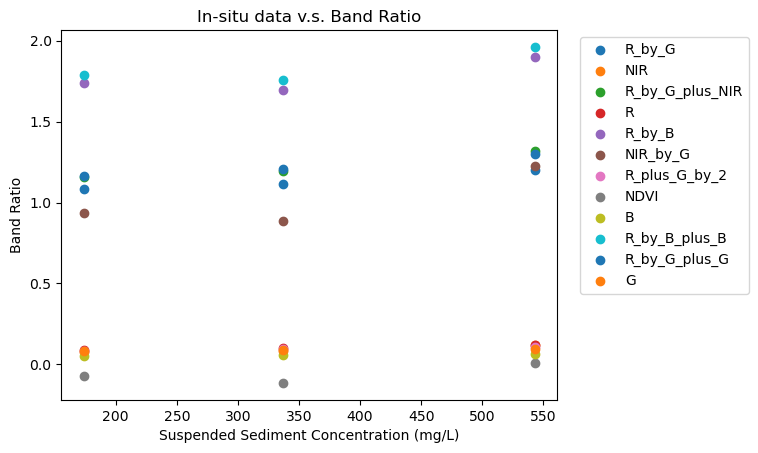

In [85]:
#investigate the linear relationship for each band (ratio)
#reflectance = [aveSpectrum_MS_upper,aveSpectrum_MO,aveSpectrum_MS_lower]
fig,ax = plt.subplots()
for i,reflectance in enumerate(bandRatioList):
    ax.scatter([Sed_MS_upper,Sed_MO,Sed_MS_lower],reflectance,label=strings[i])
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_title("In-situ data v.s. Band Ratio")
ax.set_xlabel("Suspended Sediment Concentration (mg/L)")
ax.set_ylabel("Band Ratio")
fig.savefig("./output/png/linear_gaugeData_Bandratio.png",dpi=600)
plt.show()

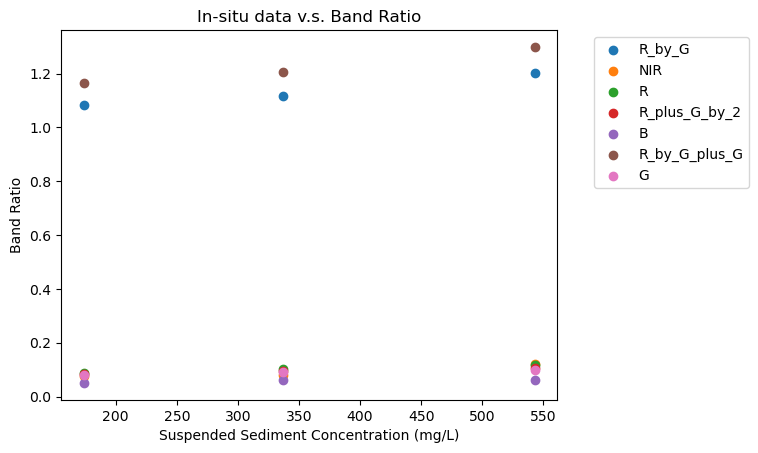

In [86]:
#investigate the linear relationship for each band (ratio)
#only a few band ratios that showed good results
#reflectance = [aveSpectrum_MS_upper,aveSpectrum_MO,aveSpectrum_MS_lower]
fig,ax = plt.subplots()
strings_selected = ["R_by_G","NIR","R","R_plus_G_by_2","B","R_by_G_plus_G","G"]
for i,reflectance in enumerate([R_by_G,NIR,R,R_plus_G_by_2,B,R_by_G_plus_G,G]):
    ax.scatter([Sed_MS_upper,Sed_MO,Sed_MS_lower],reflectance,label=strings_selected[i])
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_title("In-situ data v.s. Band Ratio")
ax.set_xlabel("Suspended Sediment Concentration (mg/L)")
ax.set_ylabel("Band Ratio")
fig.savefig("./output/png/linear_gaugeData_Bandratio_一部.png",dpi=600)
plt.show()

In [82]:
[x1,x2,x3] = R
[x12,x22,x32] =B
[Q1,Q2,Q3] = Q
A = np.array([[-1,0,0,x1,1,0,0],
             [0,-1,0,x2,1,0,0],
             [0,0,-1,x3,1,0,0],
             [-1,0,0,0,0,x12,1],
              [0,-1,0,0,0,x22,1],
              [0,0,-1,0,0,x32,1],
              [Q1,Q2,Q3,0,0,0,0]])

b = np.array([1,0,0,0,0,0,0])

x = np.linalg.solve(A,b)
print(f"x={x}")

x=[ -0.98350125   0.44335517   0.21726106  14.3918226   -1.25163499
 125.91554342  -7.36442056]


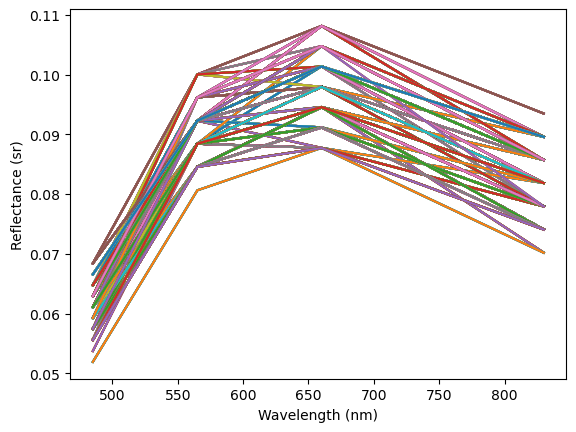

In [26]:
#直線から1km以内のnanでないところを河川として認識させる
#x = bands2dWater.coords['x']
#x = x.where(x>-90.25,drop=True)
#x = x.where(x<-90.24,drop=True)

bboxXMin,bboxXMax = -90.18,-90.177
bboxYMin,bboxYMax = 38.642,38.648
#-90.22,-90.20,38.825,38.85　ミシシッピ川合流前
#-90.112,-90.110 38.830,38.840 ミズーリ川


region = bands2d.sel(x=slice(bboxXMin,bboxXMax),y=slice(bboxYMax,bboxYMin))#,method="nearest") #yは降順なのでmax→minの順
bandlen,ylen,xlen =region.shape
#region = region.dropna(dim="band",how="all")
#print(region)
fig,ax = plt.subplots()
spectrum = [485,565,660,830]
for i in range(1,ylen-1):
    for j in range(1,xlen-1):
        #if region[:,i,j].all() != 0:  
        if region[0,i-1,j-1] != 0 and region[0,i+1,j-1] != 0 and region[0,i-1,j+1] != 0 and region[0,i-1,j+1] != 0:
            ax.plot(spectrum,region[:4,i,j])

#start 図の整形
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Reflectance (sr)")
plt.show()
            #print(region[:,i,j])
#bands2dWater.isel()

In [28]:
#water discharge data
import netCDF4
ncfilePath = "C:/Users/ishid/iis/data/GRDC-Daily.nc"
nc = netCDF4.Dataset(ncfilePath,"r")
nc.variables.keys()

dict_keys(['runoff_mean', 'area', 'country', 'geo_x', 'geo_y', 'geo_z', 'owneroforiginaldata', 'river_name', 'station_name', 'timezone', 'time', 'id'])

In [35]:
nc.variables['id'][:]
nc.variables['station_name'][:]# 'MISSISSIPPI RIVER'

array(['NEAR EUREKA, MO', 'BOLIVAR, TN', 'NEW ATHENS, IL', 'CARLYLE, IL',
       'VANDALIA, IL', 'MONEY, MS', 'HIGHWAY 51 NEAR OBION, TN',
       'NEAR ARKANSAS CITY, ARK', 'THEBES, IL', 'CHESTER, IL',
       'ST. LOUIS, MO', 'SUNFLOWER, MS', 'NEAR OLIVE BRANCH, MS',
       'NEAR BOVINA, MS', 'WEST, MS', 'VICKSBURG, MS', 'ROSETTA, MISS.',
       'NEAR WOODVILLE, MS', 'TARBERT LANDING, MS', 'WATERLOO, NE',
       'NELIGH, NE', 'NEAR UEHLING, NE', 'DUNNING, NE',
       'NEAR THEDFORD, NEBR.', 'NEAR ALCOVA, WY', 'ROSCOE, NEBR.',
       'NEAR WELDONA, CO', 'NEAR KERSEY, CO', 'HENDERSON, CO',
       'BELOW CHEESMAN LAKE, CO', 'NEAR GREELEY, CO',
       'NEAR FORT COLLINS, CO', 'NEAR KEYSTON, NEBR',
       'ABOVE SEMINOE RESERVOIRE NR SINCLAIR, WY',
       'WYOMING-NEBRASKA STATE LINE', 'ORIN, WY', 'NEAR NORTHGATE, CO',
       'ABOVE SIMINOE RESERVOIRE NEAR HANNA NY', 'ABOVE HAMBURG, IA',
       'RANDOLPH, IA (WEST)', 'AUBURN, NE', 'FALLS CITY, NE',
       'NEAR AGENCY, MO', 'RANDOLPH, KS', 

In [36]:
nc.variables['station_name']#ST. LOUIS, MO

<class 'netCDF4._netCDF4.Variable'>
vlen station_name(id)
    long_name: station name
vlen data type: <class 'str'>
unlimited dimensions: 
current shape = (154,)

In [ ]:
#water discharge data
import netCDF4
ncfilePath = "C:/Users/ishid/iis/data/GRDC-Daily.nc"
nc = netCDF4.Dataset(ncfilePath,"r")
nc.variables.keys()

dict_keys(['runoff_mean', 'area', 'country', 'geo_x', 'geo_y', 'geo_z', 'owneroforiginaldata', 'river_name', 'station_name', 'timezone', 'time', 'id'])